In [2]:
!pip install  tabulate 

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
df = pd.read_csv("C:\\Users\\Suvha\\Downloads\\BRCA.csv")

In [6]:
df

,Patient_ID,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,TCGA-D8-A1XD,36.0,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,15-Jan-17,19-Jun-17,Alive
1,TCGA-EW-A1OX,43.0,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Positive,Positive,Negative,Lumpectomy,26-Apr-17,09-Nov-18,Dead
2,TCGA-A8-A079,69.0,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,08-Sep-17,09-Jun-18,Alive
3,TCGA-D8-A1XR,56.0,FEMALE,0.345090,-0.21147,-0.19304,0.124270,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,25-Jan-17,12-Jul-17,Alive
4,TCGA-BH-A0BF,56.0,FEMALE,0.221550,1.90680,0.52045,-0.311990,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,06-May-17,27-Jun-19,Dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print("Initial Data Info:")
df.info()
print("\nMissing Values Check:\n", df.isnull().sum())
print("\nTarget Column Distribution (Patient_Status):\n", df['Patient_Status'].value_counts())

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Patient_ID          334 non-null    object 
 1   Age                 334 non-null    float64
 2   Gender              334 non-null    object 
 3   Protein1            334 non-null    float64
 4   Protein2            334 non-null    float64
 5   Protein3            334 non-null    float64
 6   Protein4            334 non-null    float64
 7   Tumour_Stage        334 non-null    object 
 8   Histology           334 non-null    object 
 9   ER status           334 non-null    object 
 10  PR status           334 non-null    object 
 11  HER2 status         334 non-null    object 
 12  Surgery_type        334 non-null    object 
 13  Date_of_Surgery     334 non-null    object 
 14  Date_of_Last_Visit  317 non-null    object 
 15  Patient_Status      321 non-null    ob

C:\Users\Suvha\AppData\Local\Temp\ipykernel_6756\128134097.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette=['#007ACC', '#CC4F1B'])


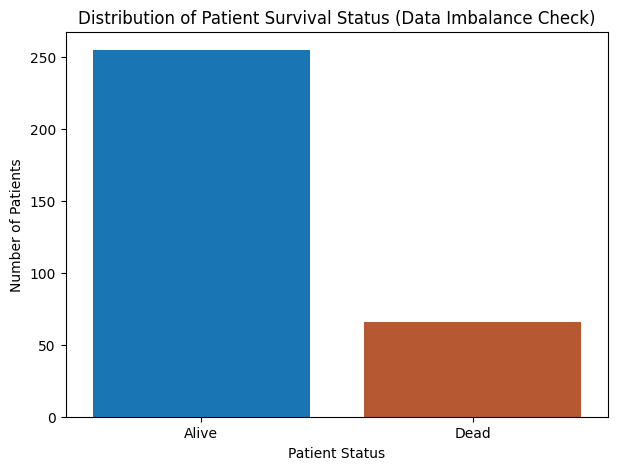

In [8]:
plt.figure(figsize=(7, 5))
status_counts = df['Patient_Status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, palette=['#007ACC', '#CC4F1B'])
plt.title('Distribution of Patient Survival Status (Data Imbalance Check)')
plt.xlabel('Patient Status')
plt.ylabel('Number of Patients')
plt.show()

In [9]:
df['Patient_Status_Encoded'] = df['Patient_Status'].apply(lambda x: 1 if x == 'Alive' else 0)


In [10]:
binary_map = {'Positive': 1, 'Negative': 0}
df['ER status'] = df['ER status'].map(binary_map)
df['PR status'] = df['PR status'].map(binary_map)
df['HER2 status'] = df['HER2 status'].map(binary_map)


In [11]:
stage_map = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
df['Tumour_Stage_Encoded'] = df['Tumour_Stage'].map(stage_map)


In [12]:
df['Date_of_Surgery'] = pd.to_datetime(df['Date_of_Surgery'], errors='coerce')
df['Date_of_Last_Visit'] = pd.to_datetime(df['Date_of_Last_Visit'], errors='coerce')
df['Survival_Days'] = (df['Date_of_Last_Visit'] - df['Date_of_Surgery']).dt.days


C:\Users\Suvha\AppData\Local\Temp\ipykernel_6756\1796004050.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date_of_Surgery'] = pd.to_datetime(df['Date_of_Surgery'], errors='coerce')
C:\Users\Suvha\AppData\Local\Temp\ipykernel_6756\1796004050.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date_of_Last_Visit'] = pd.to_datetime(df['Date_of_Last_Visit'], errors='coerce')


In [13]:
numerical_cols = ['Protein1', 'Protein2', 'Protein3', 'Protein4', 'Age', 'Survival_Days', 'Tumour_Stage_Encoded']
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

C:\Users\Suvha\AppData\Local\Temp\ipykernel_6756\722599606.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\Suvha\AppData\Local\Temp\ipykernel_6756\722599606.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [14]:
df = pd.get_dummies(df, columns=['Histology', 'Surgery_type', 'Gender'], drop_first=True)


In [15]:
exclude_cols = ['Patient_ID', 'Tumour_Stage', 'Patient_Status', 'Date_of_Surgery', 'Date_of_Last_Visit', 'Patient_Status_Encoded']
X = df.drop(columns=exclude_cols, errors='ignore')
y = df['Patient_Status_Encoded']


In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median') 
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

In [19]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [20]:
print(f"\nTraining set size (Original): {X_train.shape}")
print(f"Training set size (SMOTE): {X_train_res.shape}")
print(f"Training Target distribution (SMOTE):\n{y_train_res.value_counts()}")



Training set size (Original): (272, 16)
Training set size (SMOTE): (406, 16)
Training Target distribution (SMOTE):
Patient_Status_Encoded
1    203
0    203
Name: count, dtype: int64


In [21]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0) # Dead (0) is our positive class for precision
    recall = recall_score(y_test, y_pred, pos_label=0) 
    f1 = f1_score(y_test, y_pred, pos_label=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Dead=0)': precision, # Focus on Precision for the 'Dead' class
        'Recall (Dead=0)': recall,
        'F1-Score (Dead=0)': f1,
        'ROC-AUC': roc_auc
    }
    
    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Dead=0): {precision:.4f}")
    print(f"Recall (Dead=0): {recall:.4f}")
    print(f"F1-Score (Dead=0): {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    return results

In [22]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [23]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [24]:
grid_search_xgb = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid_xgb, 
    scoring='precision',  
    cv=5, 
    verbose=0
)

print("\nStarting XGBoost Grid Search...")
grid_search_xgb.fit(X_train_res, y_train_res)
best_xgb_model = grid_search_xgb.best_estimator_
xgb_results = evaluate_model(best_xgb_model, X_test, y_test, "XGBoost (Tuned)")


Starting XGBoost Grid Search...


C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [14:56:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [14:56:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [14:56:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [14:56:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.


--- XGBoost (Tuned) Results ---
Accuracy: 0.2609
Precision (Dead=0): 0.2258
Recall (Dead=0): 0.8235
F1-Score (Dead=0): 0.3544
ROC-AUC: 0.4514
Confusion Matrix:
 [[14  3]
 [48  4]]


In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")


--- Random Forest Results ---
Accuracy: 0.6377
Precision (Dead=0): 0.2778
Recall (Dead=0): 0.2941
F1-Score (Dead=0): 0.2857
ROC-AUC: 0.6063
Confusion Matrix:
 [[ 5 12]
 [13 39]]


In [26]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model


In [27]:
ann_model = create_ann_model(X_train_res.shape[1])

C:\Users\Suvha\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

print("\nStarting ANN Model Training...")
history = ann_model.fit(X_train_res, y_train_res, 
                        epochs=100, 
                        batch_size=32, 
                        validation_split=0.1, 
                        callbacks=[es], 
                        verbose=0)



Starting ANN Model Training...
Epoch 81: early stopping


In [29]:
y_proba_ann = ann_model.predict(X_test)
y_pred_ann = (y_proba_ann > 0.5).astype(int)
y_proba_ann_flat = y_proba_ann.flatten()

ann_precision = precision_score(y_test, y_pred_ann, pos_label=0)
ann_accuracy = accuracy_score(y_test, y_pred_ann)
ann_roc_auc = roc_auc_score(y_test, y_proba_ann_flat)

ann_results = {
    'Model': 'ANN (FNN)',
    'Accuracy': ann_accuracy,
    'Precision (Dead=0)': ann_precision,
    'ROC-AUC': ann_roc_auc
}

print("\n--- ANN (FNN) Results ---")
print(f"Accuracy: {ann_accuracy:.4f}")
print(f"Precision (Dead=0): {ann_precision:.4f}")
print(f"ROC-AUC: {ann_roc_auc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann, labels=[0, 1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

--- ANN (FNN) Results ---
Accuracy: 0.6522
Precision (Dead=0): 0.3333
ROC-AUC: 0.5837
Confusion Matrix:
 [[ 7 10]
 [14 38]]


In [30]:
all_results = [xgb_results, rf_results, ann_results]
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by='Precision (Dead=0)', ascending=False)

print("\n=======================================================")
print("  FINAL COMPARATIVE RESULTS (Focus on Precision for A+)  ")
print("=======================================================")
print(results_df.to_markdown(index=False))


  FINAL COMPARATIVE RESULTS (Focus on Precision for A+)  
| Model           |   Accuracy |   Precision (Dead=0) |   Recall (Dead=0) |   F1-Score (Dead=0) |   ROC-AUC |
|:----------------|-----------:|---------------------:|------------------:|--------------------:|----------:|
| ANN (FNN)       |   0.652174 |             0.333333 |        nan        |          nan        |  0.58371  |
| Random Forest   |   0.637681 |             0.277778 |          0.294118 |            0.285714 |  0.606335 |
| XGBoost (Tuned) |   0.26087  |             0.225806 |          0.823529 |            0.35443  |  0.451357 |


In [31]:
best_model_name = results_df.iloc[0]['Model']
best_precision = results_df.iloc[0]['Precision (Dead=0)']

print(f"\n🏆 The 'Precision Machine' for this project is: {best_model_name} ")
print(f"   (Achieved Precision for 'Dead' Class: {best_precision:.4f})")
print("=======================================================")



🏆 The 'Precision Machine' for this project is: ANN (FNN) 
   (Achieved Precision for 'Dead' Class: 0.3333)
